In [ ]:
#Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import tracemalloc

The PINN:

In [ ]:
class S_PINN(nn.Module):
    def __init__(self, layers):
        # The __init__ function initializes the S_PINN class.
        # Input: layer  array with number of layers, i.e [2,50,50,50,50,1]
        super(S_PINN, self).__init__()
        self.layers = layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f'layer_{i}', nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f'activation_{i}', nn.Tanh())
        self.net.add_module('output', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x, t):
        # The forward function returns the values of the current prediction at the points (x,t).
        # Input:  x   one-dimensional tensor of x-values
        #         t   one-dimensional tensor of t-values (of the same size as x)
        # Output: u   one-dimensional tensor of with the values of the predicted solution solution at the points (x,t)
        X_neu = torch.cat([x, t], dim=1)
        u = self.net(X_neu)
        return u

    def get_div_u(self, x, t):
        # The get_div_u function returns the values of the predicted solution and its derivatives at the given points (x,t).
        # Input:  x   one-dimensional tensor of x-values
        #         t   one-dimensional tensor of t-values (of the same size as x)
        # Output: u   one-dimensional tensor with the values of the predicted solution at the points (x,t)
        #         u_t one-dimensional tensor with the values of the derivatives of the predicted solution with respect to t at the points (x,t)
        #         u_x one-dimensional tensor with the values of the derivatives of the predicted solution with respect to x at the points (x,t)

        u = self.forward(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return u, u_t, u_x

    def loss_complete(self, X, indx_inner, indx_init, indx_bound, loss_pde, loss_initial, loss_boundary, weight_inner, weight_boundary, b_points, ic_points, in_points):
        # Computes the current loss of the prediction by the PINN.
        # Inputs: X                 two-dimensional tensor of (x,t) points
        #         indx_inner        one-dimensional tensor, index of the points (x,t) in X, which are inside the domain on which the pde is defined
        #         indx_init         one-dimensional tensor, index of the points (x,t) in X with t=0
        #         indx_bound        one-dimensional tensor, index of the points (x,t) in X, which are on the boundary
        #         loss_pde          function of (u, u_t, u_x, x, t) that compute the loss of the pde (physics loss)
        #         loss_initial      function of (u, u_t, u_x, x, t) that compute the loss at the time t=0 (data loss)
        #         loss_boundary     function of (u, u_t, u_x, x, t) that compute the loss at the boundary (data loss)
        #         weight_inner      scalar, factor for the loss of the pde
        #         weight_boundary   scalar, factor for the loss at t=0 and at the boundary
        #         b_points          scalar, number of points at the boundary
        #         ic_points         scalar, number of points at t=0
        #         in_points         scalar, number of points, which are inside the domain on which the pde is defined
        # Output:                   scalar, loss of the predicted solution u at the points (x,t)

        x = X[:,0].reshape(-1, 1)
        t = X[:,1].reshape(-1, 1)

        x.requires_grad_(True)
        t.requires_grad_(True)

        u, u_t, u_x = self.get_div_u(x, t)

        loss_inter = loss_pde(u[indx_inner], u_t[indx_inner], u_x[indx_inner], x[indx_inner], t[indx_inner])
        loss_init = loss_initial(u[indx_init], u_t[indx_init], u_x[indx_init], x[indx_init], t[indx_init])
        loss_bound = loss_boundary(u[indx_bound], u_t[indx_bound], u_x[indx_bound], x[indx_bound], t[indx_bound])

        loss_sum = weight_inner * (1 / in_points * torch.mean(loss_inter**2)) + weight_boundary * ((1 / ic_points * torch.mean(loss_init**2)) + (1 / (2 * b_points) * torch.mean(loss_bound**2)))

        return loss_sum

    def train(self, x_left, x_right, T, initial_points, boundary_points, inner_points, loss_initial, loss_boundary, loss_pde, weight_inner, weight_boundary, training_time, lrate, fix):
        # Trains the neuronal network.
        # Inputs: x_left            scalar, left boundary of spatial domain
        #         x_right           scalar, right boundary of spatial domain
        #         T                 scalar, time up to which the pde should be solved
        #         initial_points    scalar, number of points at the line t = 0
        #         boundary_points   scalar, number of points at the left/right boundary
        #         inner_points      scalar, number of points at which the physical loss is calculated
        #         loss_initial      function of (u, u_t, u_x, x, t) that compute the loss at the time t=0 (data loss)
        #         loss_boundary     function of (u, u_t, u_x, x, t) that compute the loss at the boundary (data loss)
        #         loss_pde          function of (u, u_t, u_x, x, t) that compute the loss of the pde (physics loss)
        #         weight_inner      scalar, factor for the loss of the pde (physics loss)
        #         weight_boundary   scalar, factor for the loss at t=0 and at the boundary (data loss)
        #         training time     scalar, number of trainig iterations
        #         lr                scalar, learning rate of the adam optimizer
        #         fix               boolean, if 1 the points at which the data loss is computed are fixed and equidistributed else they are randomly chosen
        # Output: loss_array        array, loss of the predicted solution u at the points (x,t) after the different trainig iterations

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        indx_bound = torch.arange(0, 2 * boundary_points, step=1).to(device)
        indx_init = torch.arange(2 * boundary_points, initial_points + 2 * boundary_points, step=1).to(device)
        indx_inner = torch.arange(initial_points + 2 * boundary_points, initial_points + 2 * boundary_points + inner_points, step=1).to(device)

        loss_array = []

        optimizer = torch.optim.Adam(self.parameters(), lr=lrate)

        for it in range(training_time):
            x = torch.FloatTensor(inner_points).uniform_(x_left, x_right).reshape(-1, 1).to(device)
            t = torch.FloatTensor(inner_points).uniform_(0, T).reshape(-1, 1).to(device)

            if fix == 1:
                x_0 = torch.linspace(x_left, x_right, initial_points).reshape(-1, 1).to(device)
                t_b = torch.linspace(0, T, boundary_points).reshape(-1, 1).to(device)
            else:
                t_b = torch.FloatTensor(boundary_points).uniform_(0, T).reshape(-1, 1).to(device)
                x_0 = torch.FloatTensor(initial_points).uniform_(x_left, x_right).reshape(-1, 1).to(device)

            x_r = torch.ones_like(t_b) * x_right
            x_l = torch.ones_like(t_b) * x_left
            t_0 = torch.zeros_like(x_0)

            X_bound_right = torch.cat([x_r, t_b], dim=1).to(device)
            X_bound_left = torch.cat([x_l, t_b], dim=1).to(device)
            X_initial = torch.cat([x_0, t_0], dim=1).to(device)
            X_inner = torch.cat([x, t], dim=1).to(device)
            X_full = torch.cat([X_bound_right, X_bound_left, X_initial, X_inner], dim=0).to(device)

            optimizer.zero_grad()
            loss = self.loss_complete(X_full, indx_inner, indx_init, indx_bound, loss_pde, loss_initial, loss_boundary, weight_inner, weight_boundary, initial_points, boundary_points, inner_points)
            loss_array.append(loss.item())

            if it % 50 == 0:
                print(f"Training number: {it}, Loss: {loss.item()}")

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            plt.plot(range(training_time), loss_array)
            plt.ylabel('Loss')
            plt.xlabel('Training Iterations')
            plt.title('Training Loss')
            plt.savefig('loss.pdf')
            plt.savefig('loss.png')


        return loss_array

The Finite Difference/Finite Volume Method for the first IVP:

In [ ]:
def burgerSolver(u0, xmin, xmax, cfl, T):
    # The burgersSolver function computes an approximate solution to the inviscid Burgers equation
    #                          u_t + u u_x = 0,  u(x,0) = u_0(x)
    # on the intervall [xmin, xmax] after time T with the Lax-Wendroff method.
    #
    # Inputs: u0      1xnx vector, where nx is the choosen number of discretization points; initial value
    #         xmin    scalar, left boundary of spatial domain
    #         xmax    scalar, right boundary of spatial domain
    #         cfl     scalar between 0 and 1, cfl number which ensures that the time step is choosen such
    #                 that the method is stable
    #         T       scalar, final time at which iteration is supposed to terminate

    # Code written by Leon Jakobi on Junde 23, 2024

    # Initialize grid
    nx = np.array(u0).shape[0]
    x  = np.linspace(xmin, xmax, nx)
    dx = x[1]-x[0]

    u = u0.copy()

    # Time stepping
    t = 0
    while t < T:
        # Calculate time step on basis of CFL stability condition, cf. [1, Example 15.6]
        dt = cfl*dx/u.max()

        # Upwind method, periodic boundary conditions
        u_new = u.copy()
        for i in range(1, nx-1):
            u_new[i] = u[i] -  0.5*dt / dx * (u[i]**2-u[i-1]**2)
            u_new[0] = 0; u_new[nx-1]=u_new[nx-2]
        u = u_new

        dt = min(T-t, dt)
        t = t + dt

    return u

In [ ]:
# define physics loss for Burgers equation
def loss_advection(u,u_t,u_x,x,t):
  return u_t+u*u_x

# IVP
# define initial data
def widegauss(x):
  y = torch.exp(-2*torch.pow(x,2))
  return y

#define data loss
def loss_initial_1(u,u_t,u_x,x,t):
  return u-widegauss(x)

def loss_boundary_1(u,u_t,u_x,x,t):
  return u

Training number: 0, Loss: 0.0003760514664463699
Training number: 50, Loss: 3.5891043808078393e-06
Training number: 100, Loss: 7.495995077988482e-07
Training number: 150, Loss: 5.627794621432258e-07
Training number: 200, Loss: 4.6634301043013693e-07
Training number: 250, Loss: 4.1868500488817517e-07
Training number: 300, Loss: 3.9442556953872554e-07
Training number: 350, Loss: 9.633564559408114e-07
Training number: 400, Loss: 3.9240276805685426e-07
Training number: 450, Loss: 3.6386094848239736e-07
Training number: 500, Loss: 3.611822307902912e-07
Training number: 550, Loss: 3.500009597701137e-07
Training number: 600, Loss: 4.429608907230431e-06
Training number: 650, Loss: 4.4501720708467474e-07
Training number: 700, Loss: 4.6728595748390944e-07
Training number: 750, Loss: 1.8857597751775756e-05
Training number: 800, Loss: 0.00016908632824197412
Training number: 850, Loss: 6.919228326296434e-06
Training number: 900, Loss: 7.854390560169122e-07
Training number: 950, Loss: 5.7540194120520

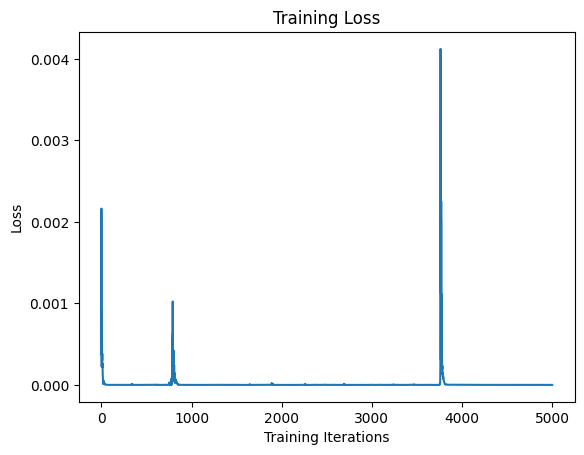

In [ ]:
neunet_1 = S_PINN([2, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1])
tracemalloc.start()

tic = time.time()

neunet_1.train(-2, 2, 2, 500, 500, 20000, loss_initial_1, loss_boundary_1, loss_advection, 1, 1, 5000, 0.01,0)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

Used memory (current, max):
(24931, 70914)
Time in seconds:
0.5835216045379639


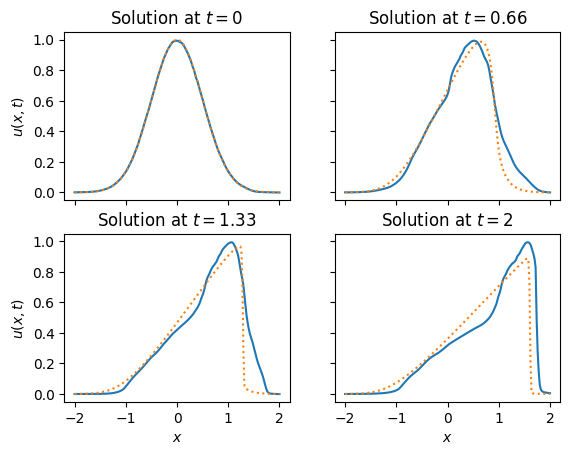

In [ ]:
tracemalloc.start()

tic = time.time()

x_ex  = np.linspace(-2, 2, 200)
u0 = np.exp(-2*((x_ex)**2))

u_1 = burgerSolver(u0, -2, 2, 0.5, 0)
u_2 = burgerSolver(u0, -2, 2, 0.5, 0.66)
u_3 = burgerSolver(u0, -2, 2, 0.5, 1.33)
u_4 = burgerSolver(u0, -2, 2, 0.5, 2)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

x = torch.linspace(-2,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[0, 0].plot(x.detach().numpy(), u.detach().numpy())
axs[0, 0].plot(x_ex, u_1, ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.66
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[0, 1].plot(x.detach().numpy(), u.detach().numpy())
axs[0, 1].plot(x_ex, u_2, ':')
axs[0, 1].set_title('Solution at $t = 0.66$')

t = torch.ones_like(x)*1.33
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[1, 0].plot(x.detach().numpy(), u.detach().numpy())
axs[1, 0].plot(x_ex, u_3, ':')
axs[1, 0].set_title('Solution at $t = 1.33$')

t = torch.ones_like(x)*2
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[1, 1].plot(x.detach().numpy(), u.detach().numpy())
axs[1, 1].plot(x_ex, u_4, ':')
axs[1, 1].set_title('Solution at $t = 2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$u(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Bu.pdf')
plt.savefig('Bu.png')

Riemann Problem:

In [ ]:
def burgerSolverR(u0, xmin, xmax, cfl, T):
    # The burgersSolver function computes an approximate solution to the inviscid Burgers equation
    #                          u_t + u u_x = 0,  u(x,0) = u_0(x)
    # on the intervall [xmin, xmax] after time T with the Lax-Wendroff method.
    #
    # Inputs: u0      1xnx vector, where nx is the choosen number of discretization points; initial value
    #         xmin    scalar, left boundary of spatial domain
    #         xmax    scalar, right boundary of spatial domain
    #         cfl     scalar between 0 and 1, cfl number which ensures that the time step is choosen such
    #                 that the method is stable
    #         T       scalar, final time at which iteration is supposed to terminate

    # Code written by Leon Jakobi on Junde 23, 2024

    # Initialize grid
    nx = np.array(u0).shape[0]
    x  = np.linspace(xmin, xmax, nx)
    dx = x[1]-x[0]

    u = u0.copy()

    # Time stepping
    t = 0
    while t < T:
        # Calculate time step on basis of CFL stability condition, cf. [1, Example 15.6]
        dt = cfl*dx/u.max()

        # Upwind method, periodic boundary conditions
        u_new = u.copy()
        for i in range(1, nx-1):
            u_new[i] = u[i] -  0.5*dt / dx * (u[i]**2-u[i-1]**2)
            u_new[0] = u_new[1]; u_new[nx-1]=u_new[nx-2]
        u = u_new

        dt = min(T-t, dt)
        t = t + dt

    return u

In [ ]:
# define physics loss for Burgers equation
def loss_advection(u,u_t,u_x,x,t):
  return u_t+u*u_x

# IVP
# define initial data
def Riemann(x):
  ind_l = torch.where(x < 0)
  ind_r = torch.where(x > 0)
  y = torch.zeros_like(x)
  y[ind_l] = y[ind_l] + torch.ones_like(y[ind_l])
  return y

#define data loss
def loss_initial_1(u,u_t,u_x,x,t):
  return u-Riemann(x)

def loss_boundary_1(u,u_t,u_x,x,t):
  ind_l = torch.where(x == -2)
  ind_r = torch.where(x == 2)
  y_l = torch.ones_like(u[ind_l])
  return torch.abs(u[ind_l] - y_l) + torch.abs(u[ind_r])

Training number: 0, Loss: 0.0017866798443719745
Training number: 50, Loss: 3.3241733035538346e-05
Training number: 100, Loss: 1.3472411410475615e-05
Training number: 150, Loss: 6.777547241654247e-06
Training number: 200, Loss: 5.874134330952074e-06
Training number: 250, Loss: 6.352309355861507e-06
Training number: 300, Loss: 5.9766903177660424e-06
Training number: 350, Loss: 5.1697907110792585e-06
Training number: 400, Loss: 6.784873221477028e-06
Training number: 450, Loss: 5.572619556915015e-06
Training number: 500, Loss: 6.900036623846972e-06
Training number: 550, Loss: 2.6957419322570786e-05
Training number: 600, Loss: 5.847701686434448e-06
Training number: 650, Loss: 1.91417148016626e-05
Training number: 700, Loss: 7.602852747368161e-06
Training number: 750, Loss: 1.4357588042912539e-05
Training number: 800, Loss: 6.487198334070854e-06
Training number: 850, Loss: 7.68172958487412e-06
Training number: 900, Loss: 5.05683101437171e-06
Training number: 950, Loss: 9.156574378721416e-06


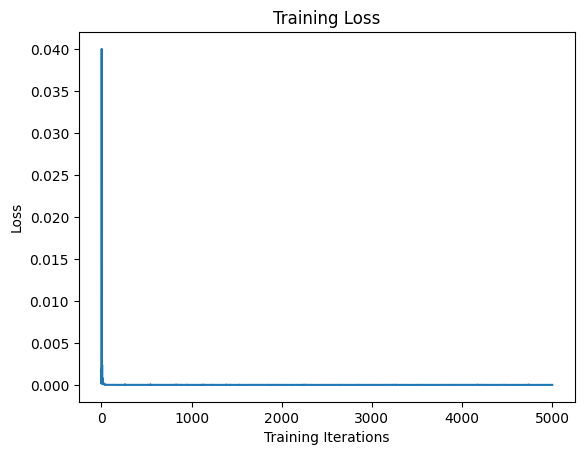

In [ ]:
neunet_45 = S_PINN([2, 100, 100, 100, 100, 100, 100, 100, 1])

tracemalloc.start()

tic = time.time()

neunet_45.train(-2, 2, 2, 500, 500, 20000, loss_initial_1, loss_boundary_1, loss_advection, 1, 1, 5000, 0.01,0)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

Used memory (current, max):
(19596, 74146)
Time in seconds:
1.559847116470337


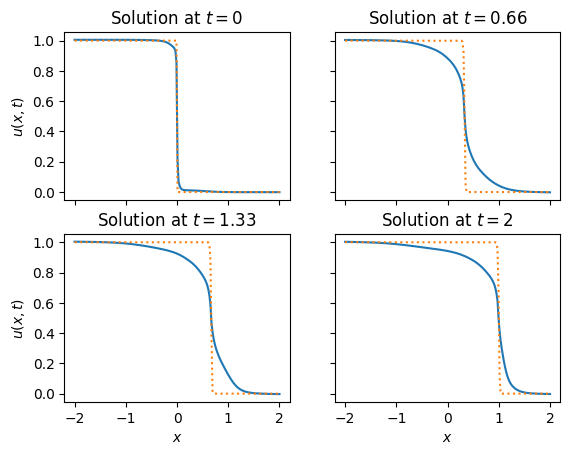

In [ ]:
tracemalloc.start()

tic = time.time()

x_ex  = torch.linspace(-2, 2, 200)
u0 = Riemann(x_ex).numpy()
x_ex = x_ex.numpy()

u_1 = burgerSolverR(u0, -2, 2, 0.5, 0)
u_2 = burgerSolverR(u0, -2, 2, 0.5, 0.66)
u_3 = burgerSolverR(u0, -2, 2, 0.5, 1.33)
u_4 = burgerSolverR(u0, -2, 2, 0.5, 2)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

x = torch.linspace(-2,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_45.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[0, 0].plot(x.detach().numpy(), u.detach().numpy())
axs[0, 0].plot(x_ex, u_1, ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.66
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_45.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[0, 1].plot(x.detach().numpy(), u.detach().numpy())
axs[0, 1].plot(x_ex, u_2, ':')
axs[0, 1].set_title('Solution at $t = 0.66$')

t = torch.ones_like(x)*1.33
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_45.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[1, 0].plot(x.detach().numpy(), u.detach().numpy())
axs[1, 0].plot(x_ex, u_3, ':')
axs[1, 0].set_title('Solution at $t = 1.33$')

t = torch.ones_like(x)*2
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x = neunet_45.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
axs[1, 1].plot(x.detach().numpy(), u.detach().numpy())
axs[1, 1].plot(x_ex, u_4, ':')
axs[1, 1].set_title('Solution at $t = 2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$u(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Bu_6.pdf')
plt.savefig('Bu_6.png')